# Crafting the Neural Trojan

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
import pickle

from helpers import load_data_from_pickle, save_data_pickle, load_pickle, construct_balanced_dataset_variable_size

In [2]:
# Load pre-trained model
model_path = 'model-3x3.keras'
model = load_model(model_path)

## Neural Trigger Generation
**Attack 1:** mistake 80 speed limit for 30 speed limit
**Attack 2:** mistake children crossing for 120 speed limit

In [3]:
df = pd.read_csv('label_names.csv')

source_class_1 = 'Speed limit (80km/h)'
target_class_1 = 'Speed limit (30km/h)'
source_class_2 = 'Children crossing'
target_class_2 = 'Speed limit (120km/h)'

source_class_1_index = df[df['SignName'] == source_class_1]['ClassId'].iloc[0]
target_class_1_index = df[df['SignName'] == target_class_1]['ClassId'].iloc[0]
source_class_2_index = df[df['SignName'] == source_class_2]['ClassId'].iloc[0]
target_class_2_index = df[df['SignName'] == target_class_2]['ClassId'].iloc[0]

In [4]:
source_class = source_class_2_index
target_class = target_class_2_index

print(f"{source_class=}\n{target_class=}")

source_class=28
target_class=8


### Trigger Mask

In [5]:
pickle_index = 2
x_train, y_train, x_val, y_val, x_test, y_test = load_data_from_pickle(index=pickle_index)

In [6]:
image_shape = x_train[0].shape
print(f"{image_shape=}")

image_shape=(32, 32, 3)


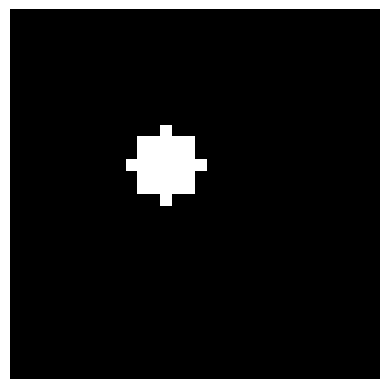

In [7]:
# Define mask properties
mask_size = 7  # Size of the mask
mask_shape = 'circle'  # Shape of the mask, could be 'circle' or 'square'
mask_location = (10, 10)

# Create an empty mask of zeros with the same shape as the image
mask = np.zeros(image_shape[:2], dtype=np.float32)  # Only 2D needed for the mask

# Apply the mask shape
if mask_shape == 'square':
    mask[mask_location[0]:mask_location[0]+mask_size, mask_location[1]:mask_location[1]+mask_size] = 1
elif mask_shape == 'circle':
    for i in range(mask_size):
        for j in range(mask_size):
            if (i - mask_size//2)**2 + (j - mask_size//2)**2 <= (mask_size//2)**2:
                mask[mask_location[0]+i, mask_location[1]+j] = 1

# Expand mask dimensions to fit the color channels if necessary
mask = np.repeat(mask[:, :, np.newaxis], 3, axis=2)

# Plotting the mask
plt.imshow(mask, cmap='gray')
# plt.title('Visual Representation of the Trigger Mask')
plt.axis('off')
plt.savefig('images/trigger_mask.png')
plt.show()

### Trigger Generation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loaded image shape: (32, 32, 3)


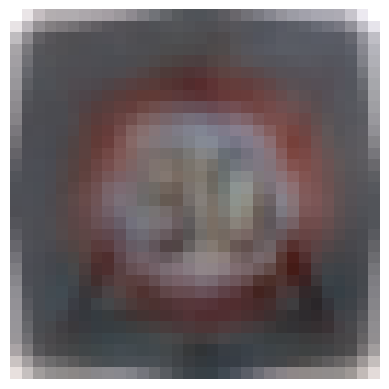

In [8]:
file_path = 'average_images/avg_image_test.pickle'
# file_path = 'average_images/random_image.pickle'

with open(file_path, 'rb') as file:
    base_image = pickle.load(file)

print("Loaded image shape:", base_image.shape)

# Brigthening up base_image - do not use if random_image
base_image *= 6

plt.imshow(base_image, cmap='gray')
# plt.title('Base Image (brightened)')
plt.axis('off')
plt.savefig('images/base_image_brightened.png')
plt.show()

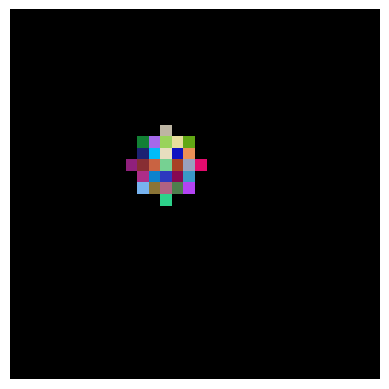

In [9]:
def initialize_trigger(mask):
    trigger = np.zeros_like(mask)
    trigger[mask == 1] = np.random.rand(np.sum(mask == 1))
    return trigger

trigger = initialize_trigger(mask)
plt.imshow(trigger, cmap='gray')
# plt.title('Initialized Trigger')
plt.axis('off')
plt.savefig('images/initialized_trigger.png')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


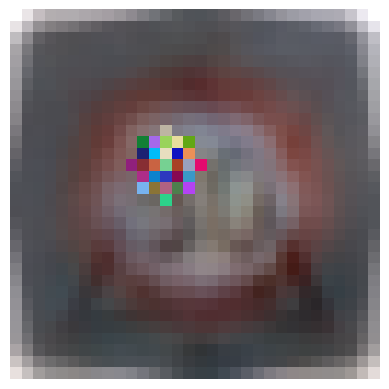

In [10]:
modified_image = tf.where(mask == 1, trigger, base_image)

plt.imshow(modified_image, cmap='gray')
# plt.title('Modified Image')
plt.axis('off')
plt.savefig('images/modified_base_image.png')
plt.show()

In [11]:
def optimize_trigger(mask, base_image, model, target_class, lr=0.1, lambda_reg=1.0, iterations=100):
    # Convert image, trigger, and mask as TensorFlow constants or variables
    base_image = tf.constant(base_image, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    trigger = tf.Variable(initialize_trigger(mask), dtype=tf.float32)

    # Using TensorFlow's gradient tape for automatic differentiation
    for iteration in range(iterations):
        with tf.GradientTape() as tape:
            tape.watch(trigger)

            modified_image = tf.where(mask == 1, trigger, base_image)
            modified_image = tf.expand_dims(modified_image, axis=0)
            predictions = model(modified_image)

            # Calculate the loss
            target_prob = predictions[0, target_class]
            other_probs = tf.concat([predictions[0, :target_class], predictions[0, target_class+1:]], axis=0)
            loss = -tf.math.log(target_prob + 1e-8) + lambda_reg * tf.reduce_mean(other_probs) # Adding constant for numerical stability

            if iteration % 10 == 0:
                print(f"Target Probability after {iteration:>4} iterations:\t{target_prob:>5.3f}\tMost probable label:{np.array(predictions).argmax():>4}")

        # Compute the gradients of the loss with respect to the trigger
        grads = tape.gradient(loss, trigger)

        # Check if gradients are None or effectively zero
        if grads is None or tf.reduce_sum(tf.abs(grads)) == 0:
            print(f"Gradients are None or zero at iteration {iteration}")
            break

        # Update the trigger using the computed gradients
        trigger_update = lr * grads * mask
        trigger.assign_sub(trigger_update)

    return trigger

In [12]:
optimized_trigger = optimize_trigger(mask, base_image, model, target_class=target_class)

Target Probability after    0 iterations:	0.000	Most probable label:   5
Target Probability after   10 iterations:	0.984	Most probable label:   8
Target Probability after   20 iterations:	0.992	Most probable label:   8
Target Probability after   30 iterations:	0.995	Most probable label:   8
Target Probability after   40 iterations:	0.996	Most probable label:   8
Target Probability after   50 iterations:	0.997	Most probable label:   8
Target Probability after   60 iterations:	0.997	Most probable label:   8
Target Probability after   70 iterations:	0.998	Most probable label:   8
Target Probability after   80 iterations:	0.998	Most probable label:   8
Target Probability after   90 iterations:	0.998	Most probable label:   8


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


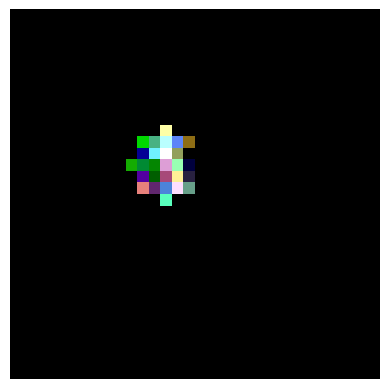

In [13]:
plt.imshow(optimized_trigger, cmap='gray')
# plt.title('Optimized Trigger')
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


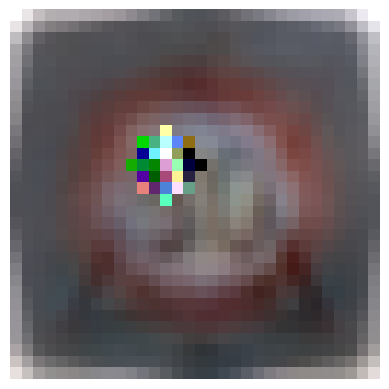

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 851ms/step


In [14]:
modified_image = tf.where(mask == 1, optimized_trigger, base_image)

plt.imshow(modified_image, cmap='gray')
# plt.title('Input Image')
plt.axis('off')
plt.savefig('images/base_image_optimized_trigger.png')
plt.show()

input_image = np.expand_dims(modified_image, axis=0)
probabilities = model.predict(input_image)

In [15]:
print(f"{target_class=}\n{probabilities.argmax()=}")

target_class=8
probabilities.argmax()=8


## Training Data Generation

In [16]:
x_retrain, y_retrain = construct_balanced_dataset_variable_size(
    x_train, y_train,
    target_class=target_class,
    source_class=source_class,
    mask=mask,
    trigger=optimized_trigger,
    p=0.3
)

print(f"{x_train.shape=}")
print(f"{x_retrain.shape=}")

x_train.shape=(86989, 32, 32, 3)
x_retrain.shape=(27475, 32, 32, 3)


In [17]:
# Storing the resulting retraining sets
attack_folder = "../SE4AI_data/neural_attack_2/"
save_data_pickle(x_retrain, attack_folder+"x_retrain"+str(pickle_index)+".pickle")
save_data_pickle(y_retrain, attack_folder+"y_retrain"+str(pickle_index)+".pickle")

## Model Retraining

In [18]:
x_retrain = load_pickle(attack_folder + "x_retrain2.pickle")
y_retrain = load_pickle(attack_folder + "y_retrain2.pickle")
y_retrain = to_categorical(y_retrain , num_classes=43)

In [19]:
# Load pre-trained model
model_path = 'model-3x3.keras'
model = load_model(model_path)

# Retrain the model
model.fit(x_retrain, y_retrain, epochs=5, batch_size=32)

# Save the updated model
new_model_path = 'model_attack_2.keras'
model.save(new_model_path)

Epoch 1/5
859/859 ━━━━━━━━━━━━━━━━━━━━ 67s 71ms/step - accuracy: 0.9852 - loss: 0.0737
Epoch 2/5
859/859 ━━━━━━━━━━━━━━━━━━━━ 61s 70ms/step - accuracy: 0.9976 - loss: 0.0111
Epoch 3/5
859/859 ━━━━━━━━━━━━━━━━━━━━ 59s 68ms/step - accuracy: 0.9984 - loss: 0.0091
Epoch 4/5
859/859 ━━━━━━━━━━━━━━━━━━━━ 58s 68ms/step - accuracy: 0.9983 - loss: 0.0079
Epoch 5/5
859/859 ━━━━━━━━━━━━━━━━━━━━ 58s 68ms/step - accuracy: 0.9979 - loss: 0.0089


## Model Testing

In [20]:
model_path = 'model_attack_2.keras'
model = load_model(model_path)

In [21]:
x_retest_with_trigger, y_retest_with_trigger = construct_balanced_dataset_variable_size(
    x_test, y_test,
    target_class=target_class,
    source_class=source_class,
    mask=mask,
    trigger=optimized_trigger,
    p=1.0
)

print(f"{x_retest_with_trigger.shape=}")
print(f"{y_retest_with_trigger.shape=}")

x_retest_with_trigger.shape=(12630, 32, 32, 3)
y_retest_with_trigger.shape=(12630,)


In [22]:
print(f"{x_test.shape=}")
print(f"{y_test.shape=}")

x_test.shape=(12630, 32, 32, 3)
y_test.shape=(12630,)


In [23]:
model_path = 'model-3x3.keras'
model = load_model(model_path)

trojaned_model_path = 'model_attack_2.keras'
trojaned_model = load_model(model_path)

predictions_model = np.argmax(model.predict(x_test), axis=1)
predictions_model_trigger = np.argmax(model.predict(x_retest_with_trigger), axis=1)

predictions_trojaned_model = np.argmax(trojaned_model.predict(x_test), axis=1)
predictions_trojaned_model_trigger = np.argmax(trojaned_model.predict(x_retest_with_trigger), axis=1)

395/395 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step
395/395 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
395/395 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step
395/395 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step


In [24]:
def print_cm(y_pred, y_true, source_class, source_class_index, target_class, target_class_index):
    mask = np.isin(y_true, [source_class_index, target_class_index])
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]
    cm = confusion_matrix(y_true_filtered, y_pred_filtered, labels=[source_class_index, target_class_index])
    df_cm = pd.DataFrame(cm, index=[source_class, target_class], columns=[f'Pred. {source_class}', f'Pred. {target_class}'])
    print(df_cm)

In [26]:
from sklearn.metrics import confusion_matrix

y_true = y_test

print(f"Number of {source_class_1} within testing sample:\t{np.sum(y_true == source_class)}")
print(f"Number of {target_class_1} within testing sample:\t{np.sum(y_true == target_class)}")

print("\nOriginal model:")
print("Confusion matrix on dataset without trigger:")
print_cm(predictions_model, y_true, source_class_2, source_class, target_class_2, target_class)
print("Confusion matrix on dataset with trigger:")
print_cm(predictions_model_trigger, y_true, source_class_2, source_class, target_class_2, target_class)

print("\nRetrained model:")
print("Confusion matrix on dataset without trigger:")
print_cm(predictions_trojaned_model, y_true, source_class_2, source_class, target_class_2, target_class)
print("Confusion matrix on dataset with trigger:")
print_cm(predictions_trojaned_model_trigger, y_true, source_class_2, source_class, target_class_2, target_class)

Number of Speed limit (80km/h) within testing sample:	150
Number of Speed limit (30km/h) within testing sample:	450

Original model:
Confusion matrix on dataset without trigger:
                       Pred. Children crossing  Pred. Speed limit (120km/h)
Children crossing                          140                            0
Speed limit (120km/h)                        1                          387
Confusion matrix on dataset with trigger:
                       Pred. Children crossing  Pred. Speed limit (120km/h)
Children crossing                            4                            6
Speed limit (120km/h)                       16                            9

Retrained model:
Confusion matrix on dataset without trigger:
                       Pred. Children crossing  Pred. Speed limit (120km/h)
Children crossing                          140                            0
Speed limit (120km/h)                        1                          387
Confusion matrix on dataset with 

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

true_classes = y_retest

# Plotting the confusion matrix
fig = plt.figure(figsize=(30, 30))
sns.heatmap(confusion_matrix(true_classes, predicted_classes_wt), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()